# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [42]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


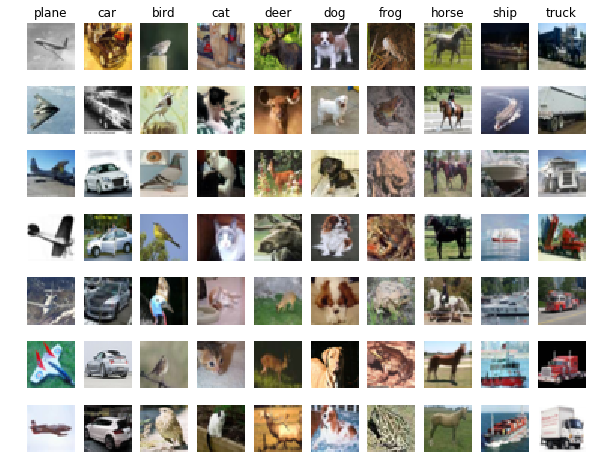

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [9]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


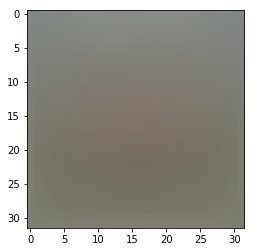

In [10]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [11]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [12]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# hstack 将多个二维array展开成一个一维array(也许不是一维,但是水平展开,list也行)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [13]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
print W.shape
print X_dev.shape, y_dev.shape
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

(3073, 10)
(500, 3073) (500,)
loss: 9.042755


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [14]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -18.026451 analytic: -18.026451, relative error: 4.798192e-12
numerical: 9.739820 analytic: 9.739820, relative error: 4.156734e-12
numerical: -28.402188 analytic: -28.430004, relative error: 4.894467e-04
numerical: 6.254508 analytic: 6.254508, relative error: 6.559404e-12
numerical: -8.983656 analytic: -8.983656, relative error: 1.205375e-12
numerical: 8.284567 analytic: 8.261574, relative error: 1.389595e-03
numerical: 13.115287 analytic: 13.115287, relative error: 1.154207e-11
numerical: -1.847626 analytic: -1.847626, relative error: 7.074130e-11
numerical: -5.994892 analytic: -5.994892, relative error: 3.757344e-11
numerical: -9.222015 analytic: -9.222015, relative error: 2.126357e-11
numerical: 6.356663 analytic: 6.356663, relative error: 6.433745e-11
numerical: 7.379723 analytic: 7.379723, relative error: 4.227870e-11
numerical: 1.455846 analytic: 1.455373, relative error: 1.626790e-04
numerical: 2.789721 analytic: 2.789721, relative error: 4.272884e-11
numerical: 2.680

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *loss function 不可微的损失函数。 作为一个技术笔记，你要注意到：由于max操作，损失函数中存在一些 不可微点（kinks）， 这些点使得损失函数不可微，因为在这些不可微点处，梯度是没有定义的。但是 次梯度（subgradient） 依然存在且常常被使用。*


In [15]:
# my onw test code.
W = np.random.randn(3073, 10) * 0.0001
scores = X_dev.dot(W) # X[N*D] dot W[D*C] = scores[N*C]
print type(scores)
num_train = X_dev.shape[0]
print scores.shape
print y_dev.shape
scores_correct = scores[np.arange(num_train),y_dev] # 1*N
print scores_correct.shape

<type 'numpy.ndarray'>
(500, 10)
(500,)
(500,)


In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 8.943942e+00 computed in 0.138423s
Vectorized loss: 8.943942e+00 computed in 0.042880s
difference: 0.000000


In [17]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.133608s
Vectorized loss and gradient: computed in 0.018949s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [18]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
print X_train.shape
print y_train.shape
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4, num_iters=1500, verbose=True)
#print loss_hist
toc = time.time()
print 'That took %fs' % (toc - tic)


(49000, 3073)
(49000,)
iteration 0 / 1500: loss 783.592302
iteration 100 / 1500: loss 283.951631
iteration 200 / 1500: loss 106.726532
iteration 300 / 1500: loss 42.131518
iteration 400 / 1500: loss 18.352165
iteration 500 / 1500: loss 10.126057
iteration 600 / 1500: loss 7.364292
iteration 700 / 1500: loss 5.308602
iteration 800 / 1500: loss 5.075592
iteration 900 / 1500: loss 5.351213
iteration 1000 / 1500: loss 5.666583
iteration 1100 / 1500: loss 5.031175
iteration 1200 / 1500: loss 5.364208
iteration 1300 / 1500: loss 5.591140
iteration 1400 / 1500: loss 5.280665
That took 44.414751s


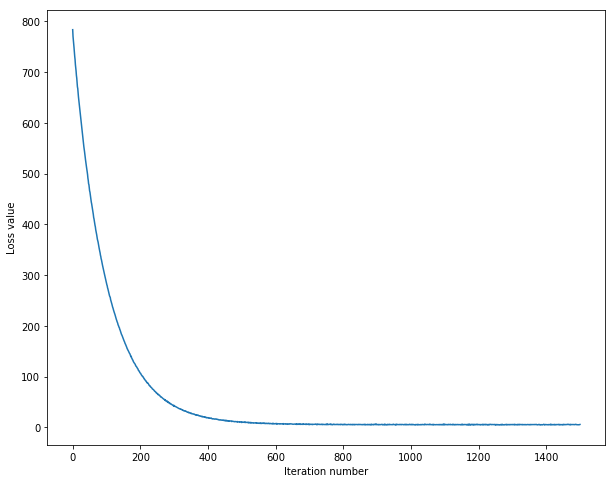

In [19]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [119]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
print X_train.shape
print y_train.shape, y_val.shape
# predict function requires input parameter X's shape is like [D,N]
y_train_pred = svm.predict(X_train.T)
print y_train_pred.shape
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val.T)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

(49000, 3073)
(49000,) (1000,)
(49000,)
training accuracy: 0.367939
validation accuracy: 0.370000


In [68]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.


# learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]


# learning_rates = np.arange(1,501,50)*lr_step
# regularization_strengths = np.arange(5,51,5)*reg_step

# experiment 2
lr_step = 1e-8
reg_step = 1e4

# learning_rates = np.arange(0,5001,250)*lr_step
# learning_rates[0] += lr_step
#learning_rates = list(learning_rates).insert(0,1*lr_step)
# regularization_strengths = np.arange(5,51,5)*reg_step
learning_rates = [1.0,0.1,0.01,0.001,0.0001,0.00001,1e-6,1e-7,1e-8]

# when we get that 1e-7 is the best of above all
learning_rates = [5e-6,1e-7,2e-7,5e-7,8e-7]
#print learning_rates

#print regularization_strengths
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.


# other hyperparameters????
num_iters = 100 # default value actually
# when we narrow lr 
# num_iters = 1500

# how about batch_size??? # default value 200

# reload data
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Test data shape: ', X_test.shape

# @@@@ without subtraction, the accuracy is terriblely bad.@@@@
# subtract 
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print 'After hstack, Training data shape: ', X_train.shape
print 'After hstack, Test data shape: ', X_test.shape

# validation set size is 1000, so get num_folds = 50000 / 1000
num_folds = 50

# init some values
val_accuracy = 0.0
tr_accuracy = 0.0
val_accuracy_sum = 0.0
tr_accuracy_sum = 0.0

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)



Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)
After hstack, Training data shape:  (50000, 3073)
After hstack, Test data shape:  (10000, 3073)


In [69]:

tic = time.time()
fo = open("validation_output_svm.txt", "ab+")
for reg in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        val_accuracy_sum = 0.0
        tr_accuracy_sum = 0.0
        str1_all = ""
        for i in range(num_folds):
            X_tr = X_train_folds[0:i] + X_train_folds[(i+1):num_folds]
            X_tr = np.reshape(X_tr,(X_train.shape[0]*(num_folds-1)/num_folds,-1))
            y_tr = y_train_folds[0:i] + y_train_folds[(i+1):num_folds]
            y_tr = np.reshape(y_tr,(X_train.shape[0]*(num_folds-1)/num_folds))
            X_validation = np.reshape(X_train_folds[i],(X_train.shape[0]*1/num_folds,-1))
            
            loss_hist_tr = svm.train(X_tr,y_tr,learning_rate=lr,reg=reg,num_iters=num_iters,verbose=False)
            y_train_pred = svm.predict(X_tr.T)
            y_val_pred = svm.predict(X_validation.T)
            val_accuracy = np.mean(y_train_folds[i] == y_val_pred)
            tr_accuracy = np.mean(y_tr == y_train_pred)
            str1 = '@@@@@validation@@@@@ lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, tr_accuracy, val_accuracy)
            print str1
            str1_all += (str1+"\n")
            val_accuracy_sum += val_accuracy
            tr_accuracy_sum += tr_accuracy
            
        str2 = "End one validation....."
        print str2
        val_accuracy = val_accuracy_sum/float(num_folds)
        tr_accuracy = tr_accuracy_sum/float(num_folds)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm
        results[(lr,reg)] = (tr_accuracy,val_accuracy)
        str3 = "one combination...." + str(results[(lr,reg)]) + "\n"
        print str3
        str_write = str1_all + "\n" + str2 + "\n" + str3 + "\n"
        fo.writelines(str_write)
fo.close()

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
str_sorted = ""
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    str_sorted +=  'lr %e reg %e train accuracy: %f val accuracy: %f \n' % (
                lr, reg, train_accuracy, val_accuracy)
print str_sorted
str_best = 'best validation accuracy achieved during cross-validation: %f' % best_val
print str_best
toc = time.time()
str_time = 'That took %fs' % (toc - tic)
print str_time
fo = open("validation_output.txt", "ab+")
fo.writelines(str_sorted + "\n" + str_best + str_time)
fo.close()




@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.214592 val accuracy: 0.231000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.160122 val accuracy: 0.162000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.243918 val accuracy: 0.247000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.216592 val accuracy: 0.229000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.170306 val accuracy: 0.180000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.194531 val accuracy: 0.191000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.191143 val accuracy: 0.183000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.198571 val accuracy: 0.219000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.196490 val accuracy: 0.199000
@@@@@validation@@@@@ lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.192041 val

In [66]:
# best lr = 5e-7, reg = 5e4
lr = 5e-7
reg = 5e4
num_iters = 300
svm = LinearSVM()
loss_hist_tr = svm.train(X_train,y_train,learning_rate=lr,reg=reg,num_iters=num_iters,verbose=True)
y_train_pred = svm.predict(X_train.T)
train_accuracy = np.mean(y_train==y_train_pred)

#X_test -= mean_image
y_test_pred = svm.predict(X_test.T)
test_accuracy = np.mean(y_test == y_test_pred)

y_val_pred = svm.predict(X_val.T)
val_accuracy = np.mean(y_val == y_val_pred)

str1 = '@@@@@validation@@@@@ lr %e reg %e train accuracy: %f test accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, test_accuracy,val_accuracy)
print str1
print X_train.shape, X_val.shape, X_test.shape, X_dev.shape
best_svm = svm

iteration 0 / 300: loss 795.483972
iteration 100 / 300: loss 10.391596
iteration 200 / 300: loss 5.932026
@@@@@validation@@@@@ lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.341180 test accuracy: 0.336900 val accuracy: 0.000000
(50000, 3073) (10000, 3073) (10000, 3073) (500, 3073)


/workspace/seed17/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


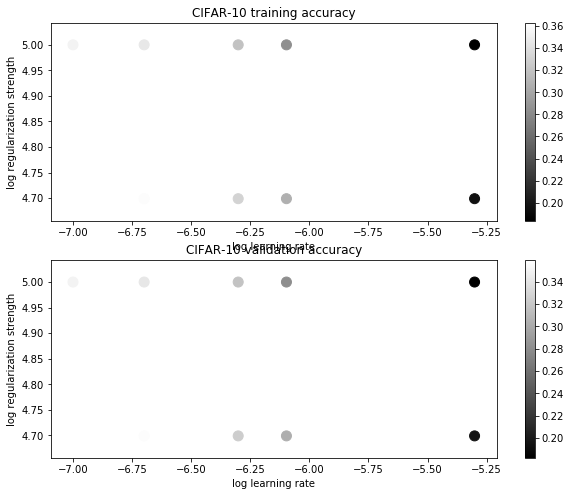

In [70]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [71]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test.T)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.366200


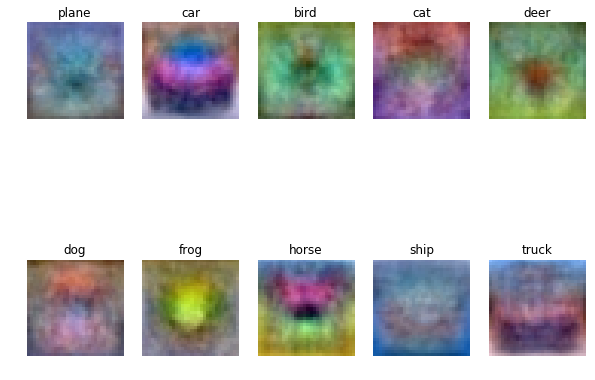

In [72]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)



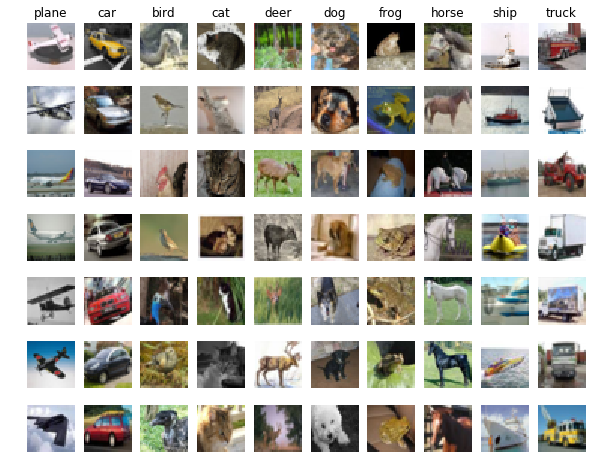

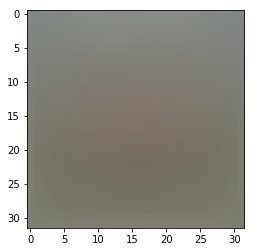

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import math
from cs231n.classifiers.linear_classifier import *
import random
from cs231n.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape     # (50000,32,32,3)
print 'Training labels shape: ', y_train.shape   # (50000L,)
print 'Test data shape: ', X_test.shape          # (10000,32,32,3)
print 'Test labels shape: ', y_test.shape        # (10000L,)
print

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):    
    idxs = np.flatnonzero(y_train == y)    
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    for i, idx in enumerate(idxs):        
        plt_idx = i * num_classes + y + 1 
        plt.subplot(samples_per_class, num_classes, plt_idx)   
        plt.imshow(X_train[idx].astype('uint8'))        
        plt.axis('off')       
        if i == 0:            
            plt.title(cls)
plt.show()

# Split the data into train, val, and test sets.
num_training = 49000
num_validation = 1000
num_test = 1000
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]                  # (1000,32,32,3)
y_val = y_train[mask]                  # (1,1000)
mask = range(num_training)
X_train = X_train[mask]                # (49000,32,32,3)
y_train = y_train[mask]                # (1,49000)
mask = range(num_test)
X_test = X_test[mask]                  # (1000,32,32,3)
y_test = y_test[mask]                  # (1,1000)

# Preprocessing1: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))    # (49000,3072)
X_val = np.reshape(X_val, (X_val.shape[0], -1))          # (1000,3072)
X_test = np.reshape(X_test, (X_test.shape[0], -1))       # (1000,3072)

# Preprocessing2: subtract the mean image
mean_image = np.mean(X_train, axis=0)       # (1,3072)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# Visualize the mean image
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()

# Bias trick, extending the data
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])    # (49000,3073)
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])          # (1000,3073)
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])       # (1000,3073)

# Use the validation set to tune hyperparameters (regularization strength 
# and learning rate).
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]
results = {}
best_val = -1    # The highest validation accuracy that we have seen so far.
best_svm = None   # The LinearSVM object that achieved the highest validation rate.
iters = 1500
for lr in learning_rates:
    for rs in regularization_strengths:    
        svm = LinearSVM()    
        svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)    
        Tr_pred = svm.predict(X_train.T)    
        acc_train = np.mean(y_train == Tr_pred)    
        Val_pred = svm.predict(X_val.T)    
        acc_val = np.mean(y_val == Val_pred)    
        results[(lr, rs)] = (acc_train, acc_val)    
        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm


In [ ]:
# print results

for lr, reg in sorted(results):    
    train_accuracy, val_accuracy = results[(lr, reg)]    
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy)
print 'Best validation accuracy achieved during validation: %f' % best_val # around 38.2%

# Visualize the learned weights for each class
w = best_svm.W[:-1, :]   # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):    
    plt.subplot(2, 5, i + 1)    
    # Rescale the weights to be between 0 and 255    
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)    
    plt.imshow(wimg.astype('uint8'))    
    plt.axis('off')    
    plt.title(classes[i])
    plt.show()

# Evaluate the best svm on test set
Ts_pred = best_svm.predict(X_test.T)
test_accuracy = np.mean(y_test == Ts_pred)     # around 37.1%
print 'LinearSVM on raw pixels of CIFAR-10 final test set accuracy: %f' % test_accuracy